In [1]:
%load_ext lab_black

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def visualize_mesh(pos, face):
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(
        pos[:, 0], pos[:, 1], pos[:, 2], triangles=data.face.t(), antialiased=False
    )
    plt.show()


def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
            src = pos[src].tolist()
            dst = pos[dst].tolist()
            plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color="black")
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
        mask = torch.zeros(pos.size(0), dtype=torch.bool)
        mask[index] = True
        plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color="lightgray", zorder=1000)
        plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis("off")
    plt.show()

# Point Cloud Classification with Graph Neural Networks

In this tutorial, you will learn the basic tools for **point cloud classification with Graph Neural Networks**.
Here, we are given a dataset of objects or point sets, and we want to embed those objects in such a way so that they are linearly separable given a task at hand.
Specifially, the raw point cloud is used as input into a neural network and will learn to capture meaningful local structures in order to classify the entire point set.

Let's dive in by looking at a simple toy dataset provided by [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric), the **[`GeoemtricShapes`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.GeometricShapes) dataset**.


## Data Handling

The `GeometricShapes` dataset contains 40 different 2D and 3D geometric shapes such as cubes, spheres and pyramids.
There exists two different versions of each shape, and one is used for training the neural network and the other is used to evaluate its performance.

GeometricShapes(40)
Data(pos=[32, 3], face=[3, 30], y=[1])


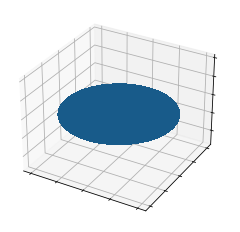

Data(pos=[4, 3], face=[3, 2], y=[1])


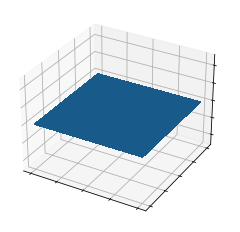

In [3]:
from torch_geometric.datasets import GeometricShapes

dataset = GeometricShapes(root="data/GeometricShapes")
print(dataset)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

We can easily import and instantiate the `GeometricShapes` dataset via PyTorch Geometric, and print out some information, *e.g.*, the description of the dataset or some information about the attributes present inside a single example.
In particular, each object is represented as a **mesh**, holding information about the vertices in `pos` and the triangular connectivity of vertices in `face` (with shape `[3, num_faces]`).

## Point Cloud Generation

Since we are interested in point cloud classification, we can transform our meshes into points via the usage of "transforms".
Here, PyTorch Geometric provides the [`torch_geometric.transforms.SamplePoints`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.SamplePoints) transformation, which will uniformly sample a fixed number of points on the mesh faces according to their face area.

We can add this transformation to the dataset by simply setting it via `dataset.transform = SamplePoints(num=...)`.
Each time an example is accessed from the dataset, the transformation procedure will get called: 

Data(pos=[256, 3], y=[1])


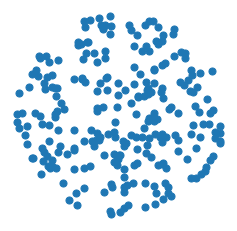

Data(pos=[256, 3], y=[1])


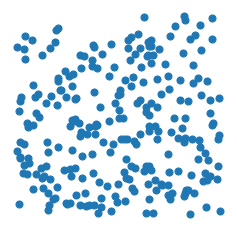

In [4]:
import torch
from torch_geometric.transforms import SamplePoints

torch.manual_seed(42)

dataset.transform = SamplePoints(num=256)

data = dataset[0]
print(data)
visualize_points(data.pos, data.edge_index)

data = dataset[4]
print(data)
visualize_points(data.pos)

## PointNet++

Since we now have a point cloud dataset ready to use, let's look into how we can process it via Graph Neural Networks and the help of the PyTorch Geometric library.

Here, we will re-implement the **[PointNet++](https://arxiv.org/abs/1706.02413) architecture**, a pioneering work towards point cloud classification/segmentation via Graph Neural Networks.

PointNet++ processes point clouds iteratively by following a simple grouping, neighborhood aggregation and downsampling scheme:

1. The **grouping phase** constructs a graph in which nearby points are connected. Typically, this is either done via  $k$-nearest neighbor search or via ball queries (which connects all points that are within a radius to the query point).

2. The **neighborhood aggregation phase** executes a Graph Neural Network layer that, for each point, aggregates information from its direct neighbors (given by the graph constructed in the previous phase).
This allows PointNet++  to capture local context at different scales.

3. The **downsampling phase** implements a pooling scheme suitable for point clouds with potentially different sizes. We will ignore this phase for now and will come back later to it.

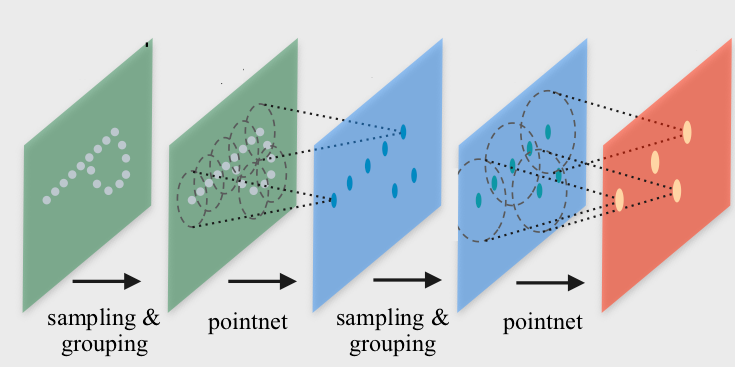

### Phase 1: Grouping via Dynamic Graph Generation

PyTorch Geometric provides utilities for dynamic graph generation via its helper package [`torch_cluster`](https://github.com/rusty1s/pytorch_cluster), in particular via the [`knn_graph`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.knn_graph) and [`radius_graph`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.radius_graph) functions for $k$-nearest neighbor and ball query graph generation, respectively.

Let's see the `knn_graph` functionality in action:

torch.Size([2, 1536])


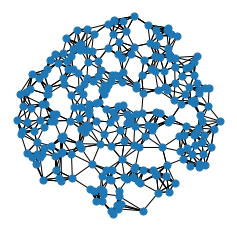

torch.Size([2, 1536])


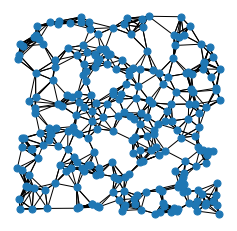

In [5]:
from torch_cluster import knn_graph

data = dataset[0]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

data = dataset[4]
data.edge_index = knn_graph(data.pos, k=6)
print(data.edge_index.shape)
visualize_points(data.pos, edge_index=data.edge_index)

Here, we import the `knn_graph` function from `torch_cluster` and call it by passing in the input points `pos` and the number of nearest neighbors `k`.
As output, we will receive an `edge_index` tensor of shape `[2, num_edges]`, which will hold the information of source and target node indices in each column (known as the sparse matrix COO format).

## Phase 2: Neighborhood Aggregation

The **[PointNet++](https://arxiv.org/abs/1706.02413) layer** follows a simple *neural message passing scheme* defined via

$$
\mathbf{h}^{(\ell + 1)}_i = \max_{j \in \mathcal{N}(i)} \textrm{MLP} \left( \mathbf{h}_j^{(\ell)}, \mathbf{p}_j - \mathbf{p}_i \right)
$$
where
* $\mathbf{h}_i^{(\ell)} \in \mathbb{R}^d$ denotes the hidden features of point $i$ in layer $\ell$
* $\mathbf{p}_i \in \mathbb{R}^3$ denotes the position of point $i$.

We can make use of the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) interface to implement this layer.
The `MessagePassing` interface helps us in **creating message passing graph neural networks** by automatically taking care of message propagation.
Here, we only need to define its `message` function as well as  which aggregation scheme to use, *.e.g.*, `aggr="max"` (see [here](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) for the accompanying tutorial):

In [6]:
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing


class PointNetLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        # Message passing with "max" aggregation.
        super(PointNetLayer, self).__init__("max")

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden node
        # dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(
            Linear(in_channels + 3, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self, h, pos, edge_index):
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self, h_j, pos_j, pos_i):
        # h_j defines the features of neighboring nodes as shape [num_edges, in_channels]
        # pos_j defines the position of neighboring nodes as shape [num_edges, 3]
        # pos_i defines the position of central nodes as shape [num_edges, 3]

        input = pos_j - pos_i  # Compute spatial relation.

        if h_j is not None:
            # In the first layer, we may not have any hidden node features,
            # so we only combine them in case they are present.
            input = torch.cat([h_j, input], dim=-1)

        return self.mlp(input)  # Apply our final MLP.

As one can see, implementing the PointNet++ layer is quite straightforward in PyTorch Geometric.
In the `__init__` function, we first define that we want to apply **`max` aggregation**, and afterwards initialize an MLP that takes care of transforming neighboring node features and the spatial relation between source and destination nodes to a (trainable) message.

In the `forward` function, we can start **propagating messages** based on `edge_index`, and pass in everything needed in order to create messages.
In the `message` function, we can now access neighboring and central node information via `*_j` and `*_i`, respectively, and return a message for each edge.

## Network Architecture

We can make use of `knn_graph` and the `PointNetLayer` to define our network architecture.
Here, we are interested in an architecture that is able to operate on point clouds in a **mini-batch fashion**.
PyTorch Geometric achieves parallelization over mini-batches by creating sparse block diagonal adjacency matrices (defined by `edge_index`) and concatenating feature matrices in the node dimension (such as `pos`).
For distinguishing examples in a mini-batch, there exists a special vector named [**`batch`**](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#mini-batches) of shape `[num_nodes]`, which maps each node to its respective graph in the batch:
$$
\textrm{batch} = {[ 0 \cdots 0, 1 \cdots n-2 n-1 \cdots n - 1 ]}^{\top}
$$

We need to make use of this `batch` vector for the `knn_graph` generation since we do not want to connect nodes from different examples.

With this, our overall `PointNet` architecture looks as follows:

In [7]:
import torch
import torch.nn.functional as F
from torch_cluster import knn_graph
from torch_geometric.nn import global_max_pool


class PointNet(torch.nn.Module):
    def __init__(self):
        super(PointNet, self).__init__()

        torch.manual_seed(12345)
        self.conv1 = PointNetLayer(3, 32)
        self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, batch):
        # Compute the kNN graph:
        # Here, we need to pass the batch vector to the function call in order
        # to prevent creating edges between points of different examples.
        # We also add `loop=True` which will add self-loops to the graph in
        # order to preserve central point information.
        edge_index = knn_graph(pos, k=16, batch=batch, loop=True)

        # 3. Start bipartite message passing.
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        h = h.relu()

        # 4. Global Pooling.
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # 5. Classifier.
        return self.classifier(h)


model = PointNet()
print(model)

PointNet(
  (conv1): PointNetLayer(
    (mlp): Sequential(
      (0): Linear(in_features=6, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (conv2): PointNetLayer(
    (mlp): Sequential(
      (0): Linear(in_features=35, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


Here, we create our network architecture by inheriting from **`torch.nn.Module`** and initialize **two `PointNetLayer` modules** and a **final linear classifier** ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) in its constructor.

In the `forward` method, we first dynamically generate a **16-nearest neighbor graph** based on the position `pos` of nodes.
Based on the resulting graph connectivity, we apply two graph-based convolutional operators and enhance them by ReLU non-linearities.
The first operator takes in 3 input features (the positions of nodes) and maps them to 32 output features.

After that, each point holds information about **its 2-hop neighborhood**, and should already be able to distinguish between simple local shapes.

Next, we apply a **global graph readout function**, *i.e.*, `global_max_pool`, which takes the maximum value along the node dimension for each example.
Last, we apply a linear classifier to map the remaining 32 features to **one of the 40 classes**.

## Training Procedure

We are now ready to write two simple procedures to train and test our model on the training and test dataset, respectively.
If you are not new to PyTorch, this scheme should appear familar to you.
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

In [8]:
from IPython.display import Javascript  # Restrict height of output cell.

display(
    Javascript("""google.colab.output.setIframeHeight(0, true, {maxHeight: 300})""")
)

from torch_geometric.loader import DataLoader

train_dataset = GeometricShapes(
    root="data/GeometricShapes", train=True, transform=SamplePoints(128)
)
test_dataset = GeometricShapes(
    root="data/GeometricShapes", train=False, transform=SamplePoints(128)
)


train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.


def train(model, optimizer, loader):
    model.train()

    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.batch)  # Forward pass.
        loss = criterion(logits, data.y)  # Loss computation.
        loss.backward()  # Backward pass.
        optimizer.step()  # Update model parameters.
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)


for epoch in range(1, 51):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f"Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}")

<IPython.core.display.Javascript object>

Epoch: 01, Loss: 3.7417, Test Accuracy: 0.0500
Epoch: 02, Loss: 3.6927, Test Accuracy: 0.0250
Epoch: 03, Loss: 3.6678, Test Accuracy: 0.0500
Epoch: 04, Loss: 3.6418, Test Accuracy: 0.0500
Epoch: 05, Loss: 3.6065, Test Accuracy: 0.0250
Epoch: 06, Loss: 3.5239, Test Accuracy: 0.0250
Epoch: 07, Loss: 3.4593, Test Accuracy: 0.0500
Epoch: 08, Loss: 3.4031, Test Accuracy: 0.0750
Epoch: 09, Loss: 3.3603, Test Accuracy: 0.1250
Epoch: 10, Loss: 3.2833, Test Accuracy: 0.1000
Epoch: 11, Loss: 3.2131, Test Accuracy: 0.0750
Epoch: 12, Loss: 3.1571, Test Accuracy: 0.1500
Epoch: 13, Loss: 3.0433, Test Accuracy: 0.2250
Epoch: 14, Loss: 2.9361, Test Accuracy: 0.2250
Epoch: 15, Loss: 2.8487, Test Accuracy: 0.2250
Epoch: 16, Loss: 2.7454, Test Accuracy: 0.2750
Epoch: 17, Loss: 2.4577, Test Accuracy: 0.2500
Epoch: 18, Loss: 2.3837, Test Accuracy: 0.3750
Epoch: 19, Loss: 2.1588, Test Accuracy: 0.3750
Epoch: 20, Loss: 2.0266, Test Accuracy: 0.4750
Epoch: 21, Loss: 1.9860, Test Accuracy: 0.3750
Epoch: 22, Lo

As one can see, we are able to achieve around **75-80% test accuracy**, even when training only on a single example per class (note that we can certainly increase performance by training longer and make use of deeper neural networks).

**However, there is one caveat:**
Since our model takes in node positions as input features, and uses relational Cartesian coordinates for creating messages, *i.e.* $\mathbf{p}_j - \mathbf{p}_i$, it does not generalize across different rotations applied to the input point cloud.

Let's verify this in an example, where we apply random rotations to the test data by composing [`RandomRotate`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.RandomRotate) transformations along different axes:

Data(pos=[32, 3], face=[3, 30], y=[1])


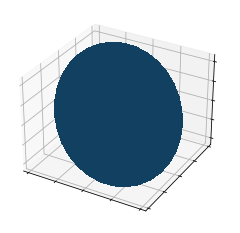

Data(pos=[4, 3], face=[3, 2], y=[1])


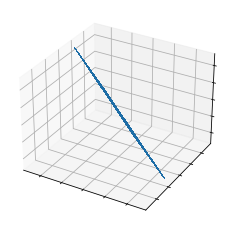

In [9]:
from torch_geometric.transforms import Compose, RandomRotate

torch.manual_seed(123)

random_rotate = Compose(
    [
        RandomRotate(degrees=180, axis=0),
        RandomRotate(degrees=180, axis=1),
        RandomRotate(degrees=180, axis=2),
    ]
)

dataset = GeometricShapes(root="data/GeometricShapes", transform=random_rotate)

data = dataset[0]
print(data)
visualize_mesh(data.pos, data.face)

data = dataset[4]
print(data)
visualize_mesh(data.pos, data.face)

In [10]:
torch.manual_seed(42)

transform = Compose(
    [
        random_rotate,
        SamplePoints(num=128),
    ]
)

test_dataset = GeometricShapes(
    root="data/GeometricShapes", train=False, transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=10)

test_acc = test(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.2500


What a bummer!
By randomly rotating the examples in our test dataset, our model performance **decreased to 30%**.

The good thing is that there are ways to fix this, so let's learn about rotation-invariant point cloud processing in the upcoming exercise.


## (Optional) Exercises

### 1. Rotation-invariant PointNet Layer

The **[PPFNet](https://arxiv.org/abs/1802.02669)** is an extension to the PointNet++ architecture that makes it **rotation-invariant**.
More specifically, PPF stands for **Point Pair Feature**, which describes the relation between two points by a rotation-invariant 4D descriptor
$$
\left( \| \mathbf{p}_j - \mathbf{p}_i \|_2, \angle(\mathbf{n}_i, \mathbf{p}_j - \mathbf{p}_i), \angle(\mathbf{n}_j, \mathbf{p}_j - \mathbf{p}_i), \angle(\mathbf{n}_i, \mathbf{n}_j) \right)
$$
based on
1. the distance between points $\| \mathbf{p}_j - \mathbf{p}_i \|_2$ and
2. the angles between $\mathbf{p}_j - \mathbf{p}_i$ and the **normal vectors** $\mathbf{n}_i$ and $\mathbf{n}_j$ of points $i$ and $j$, respectively.

Luckily, in addition to the [`PointConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.PointConv), PyTorch Geometric also provides an implementation of the `PointConv` based on the Point Pair Feature descriptor, see **[`PPFConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.PPFConv)**.
Furthermore, the [`SamplePoints`](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html) transformation does also provide **normal vectors** in `data.normal` for each sampled point when called via `SamplePoints(num_points, include_normals=True)`.

As an exercise, can you extend the example code below in order to instantiate the `PPFConv` modules?

**Tipp**:

The `PPFConv` expects an MLP as first argument, which is similar to the one created earlier in the `PointNetLayer`. Note that in `PPFConv`, we now have a 4D discriptor instead of a 3D one.

In [11]:
from torch_geometric.nn import PPFConv
from torch_cluster import fps


class PPFNet(torch.nn.Module):
    def __init__(self):
        super(PPFNet, self).__init__()

        torch.manual_seed(12345)
        mlp1 = ...  # TODO
        self.conv1 = PPFConv(...)  # TODO
        mlp2 = ...  # TODO
        self.conv2 = PPFConv(...)  # TODO
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self, pos, normal, batch):
        edge_index = knn_graph(pos, k=16, batch=batch, loop=False)

        x = self.conv1(x=None, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()
        x = self.conv2(x=x, pos=pos, normal=normal, edge_index=edge_index)
        x = x.relu()

        x = global_max_pool(x, batch)  # [num_examples, hidden_channels]
        return self.classifier(x)


model = PPFNet()
print(model)

PPFNet(
  (conv1): PPFConv(local_nn=Ellipsis, global_nn=None)
  (conv2): PPFConv(local_nn=Ellipsis, global_nn=None)
  (classifier): Linear(in_features=32, out_features=40, bias=True)
)


In [12]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

test_transform = Compose([
    random_rotate,
    SamplePoints(num=128, include_normals=True),
])

train_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=SamplePoints(128, include_normals=True))
test_dataset = GeometricShapes(root='data/GeometricShapes', train=False,
                               transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10)

model = PPFNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

def train(model, optimizer, loader):
    model.train()
    
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()  # Clear gradients.
        logits = model(data.pos, data.normal, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs

    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(model, loader):
    model.eval()

    total_correct = 0
    for data in loader:
        logits = model(data.pos, data.normal, data.batch)
        pred = logits.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())

    return total_correct / len(loader.dataset)

for epoch in range(1, 101):
    loss = train(model, optimizer, train_loader)
    test_acc = test(model, test_loader)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

<IPython.core.display.Javascript object>

TypeError: 'ellipsis' object is not callable

### 2. Downsampling Phase via Farthest Point Sampling

So far, we haven't made use of downsampling/pooling the point cloud.
In the PointNet++ architecture, downsampling of a point clouds is achieved via the **Farthest Point Sampling** (FPS) procedure, which, in return, allows the network to extract more and more global features.
Given an input point set $\{ \mathbf{p}_1, \ldots \mathbf{p}_n \}$, FPS iteratively selects a subset of points such that the sampled points are furthest apart.
Specifically, compared with random sampling, this procedure is known to have better coverage of the entire point set.

Luckily, PyTorch Geometric provides a ready-to-use implementation of [`fps`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.fps), which takes in the position of nodes and a sampling ratio, and returns the indices of nodes that have been sampled:

In [ ]:
from torch_cluster import fps

dataset = GeometricShapes(root='data/GeometricShapes', transform=SamplePoints(128))

data = dataset[0]
index = fps(data.pos, ratio=0.25)

visualize_points(data.pos)
visualize_points(data.pos, index=index)


With this, can you modify the `PPFNet` model to include a farthest point sampling step (`ratio=0.5`) in between the two convolution operators?

**Tipp:**

For `fps`, you also need to pass in the `batch` vector, so that points in different examples are sampled independently from each other:
```
index = fps(pos, batch, ratio=0.5)
```
You can now pool the points, their normals, the features and the batch vector via:
```
pos = pos[index]
normal = normal[index]
h = h[index]
batch = batch[index]
```
This will just keep the points sampled by `fps`.

Note that you also need to create a new $k$-NN graph after applying the pooling operation.